In [1]:
import pandas as pd
import numpy as np

In [2]:
events = pd.read_excel("Event.xlsx")
target_names = events.Type.unique().tolist()

In [3]:
events

,Events,Type,Unnamed: 2
0,Introducing The Management 2.0 Hackathon,Management.Hackathons,NaN
1,Join us live online on September 10th at 9:30 ...,Management.Webinars,NaN
2,Learn and practise your delegation skills with...,Management.Webinars,NaN
3,Upcoming Online Seminar: The Future of Managem...,Management.Webinars,NaN
4,World's biggest coding event - TechGig Code Gl...,Coding.Hackathons,NaN
...,...,...,...
347,Join the C Developer Conference happening Tomo...,C.Seminars,NaN
348,Seminar - Objective C and Its uses,C.Seminars,NaN
349,To C or Not to C. A deep dive conference aout ...,C.Seminars,NaN
350,C is everywhere but we just don’t see it. Join...,C.Seminars,NaN


In [4]:
events['category_id'] = events['Type'].factorize()[0]

In [5]:
category_id_df = events[['Type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Type']].values)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(events.Events).toarray()
labels = events.Type
features.shape

(352, 116)

In [19]:
from sklearn.feature_selection import chi2
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Artificial_Intelligence.Certifications':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android ios
. chance win
# 'Artificial_Intelligence.Courses':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android ios
. chance win
# 'Artificial_Intelligence.Expos':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android ios
. chance win
# 'Artificial_Intelligence.Fests':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android ios
. chance win
# 'Artificial_Intelligence.Hackathons':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android ios
. chance win
# 'Artificial_Intelligence.Internships':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android ios
. chance win
# 'Artificial_Intelligence.Jobs':
  . Most correlated unigrams:
. developers
. world
  . Most correlated bigrams:
. android io

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(events.Events, events.Type, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [39]:
print(clf.predict(count_vect.transform(["Internship Opportunity: Full time python job"])))

['Mobile_Applications.Jobs']


C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), U

NameError: name 'plt' is not defined

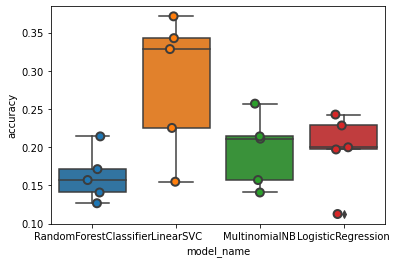

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [33]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, events.index, test_size=0.15, random_state=0)

In [34]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

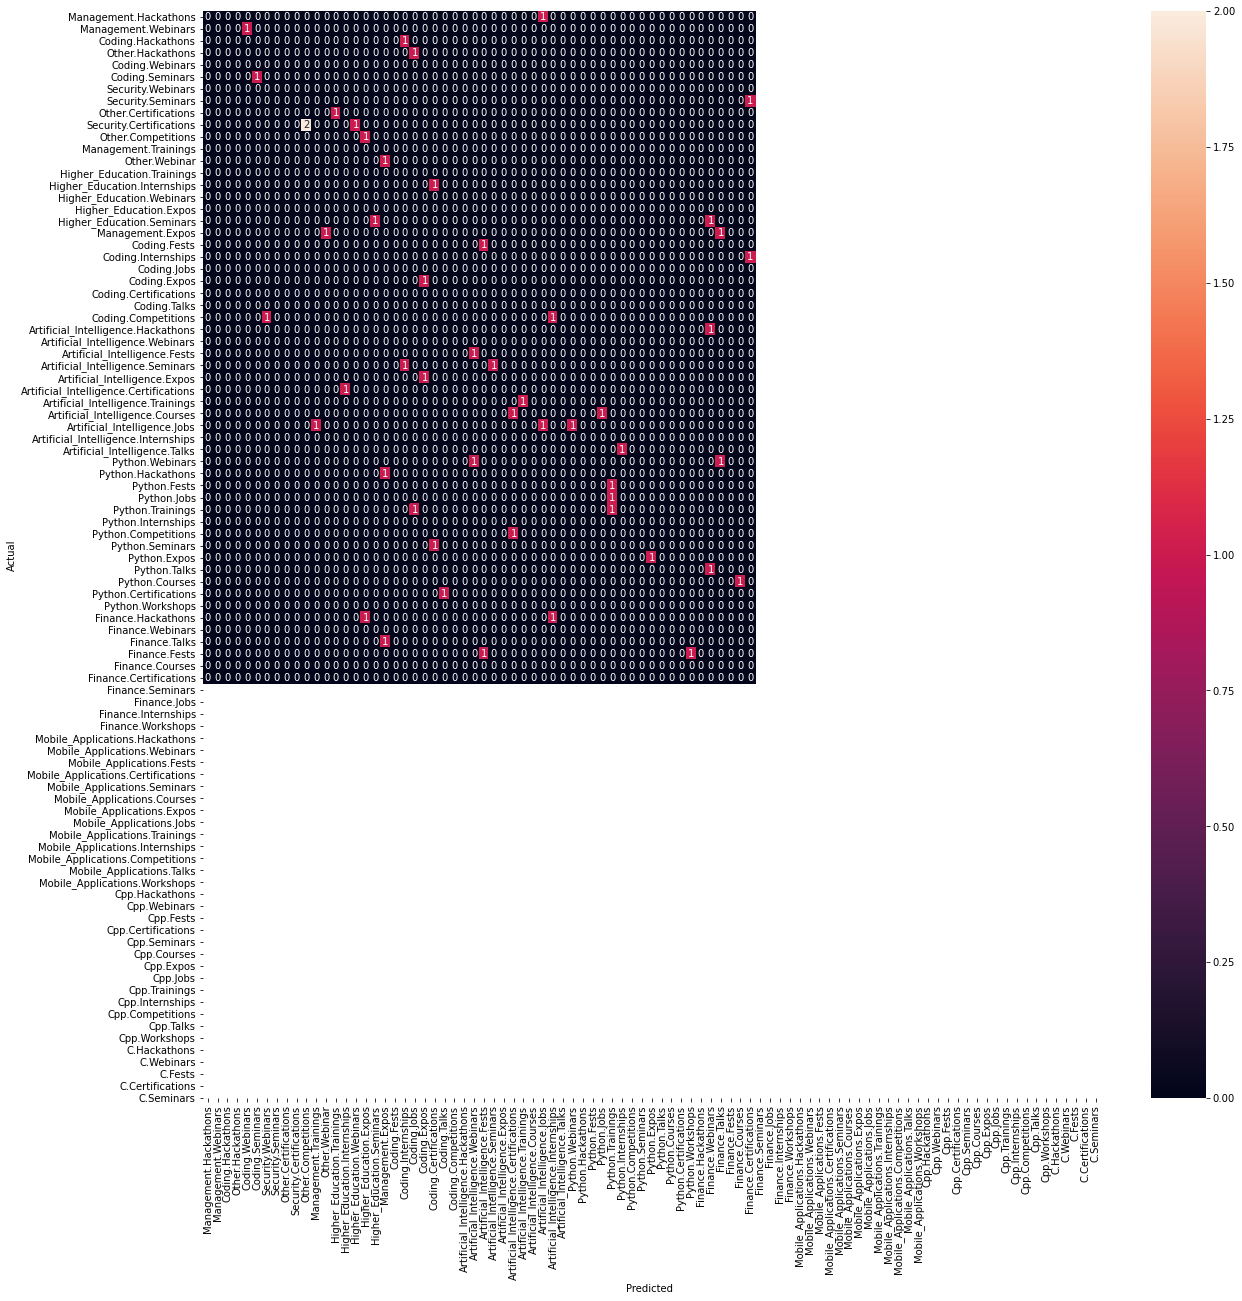

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [41]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [42]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Artificial_Intelligence.Certifications':
  . Top unigrams:
       . challenge
       . hackathon
  . Top bigrams:
       . chance win
       . internship opportunity
# 'Artificial_Intelligence.Courses':
  . Top unigrams:
       . position
       . senior
  . Top bigrams:
       . work home
       . programming language
# 'Artificial_Intelligence.Expos':
  . Top unigrams:
       . festival
       . sign
  . Top bigrams:
       . chance win
       . live online
# 'Artificial_Intelligence.Fests':
  . Top unigrams:
       . courses
       . programming
  . Top bigrams:
       . registrations open
       . online session
# 'Artificial_Intelligence.Hackathons':
  . Top unigrams:
       . multiple
       . programmer
  . Top bigrams:
       . application development
       . mobile apps
# 'Artificial_Intelligence.Internships':
  . Top unigrams:
       . talk
       . world
  . Top bigrams:
       . work home
       . live online
# 'Artificial_Intelligence.Jobs':
  . Top unigrams:
       . 

In [44]:
id_to_category

{0: 'Management.Hackathons',
 1: 'Management.Webinars',
 2: 'Coding.Hackathons',
 3: 'Other.Hackathons',
 4: 'Coding.Webinars',
 5: 'Coding.Seminars',
 6: 'Security.Webinars',
 7: 'Security.Seminars',
 8: 'Other.Certifications',
 9: 'Security.Certifications',
 10: 'Other.Competitions',
 11: 'Management.Trainings',
 12: 'Other.Webinar',
 13: 'Higher_Education.Trainings',
 14: 'Higher_Education.Internships',
 15: 'Higher_Education.Webinars',
 16: 'Higher_Education.Expos',
 17: 'Higher_Education.Seminars',
 18: 'Management.Expos',
 19: 'Coding.Fests',
 20: 'Coding.Internships',
 21: 'Coding.Jobs',
 22: 'Coding.Expos',
 23: 'Coding.Certifications',
 24: 'Coding.Talks',
 25: 'Coding.Competitions',
 26: 'Artificial_Intelligence.Hackathons',
 27: 'Artificial_Intelligence.Webinars',
 28: 'Artificial_Intelligence.Fests',
 29: 'Artificial_Intelligence.Seminars',
 30: 'Artificial_Intelligence.Expos',
 31: 'Artificial_Intelligence.Certifications',
 32: 'Artificial_Intelligence.Trainings',
 33: 'Ar

In [45]:
texts = ["Get a job as a senior Python Developer Now!",
         "The World's largest python conference is out now",
         "Webinar Series: The advent of AI",
         "Stand out with this comprehensive course on finance and investments",
         "COHO C++ Festival begins soon. Book your Tickets today!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(predicted))
  print("")

"Get a job as a senior Python Developer Now!"
  - Predicted as: 'Python.Jobs'

"The World's largest python conference is out now"
  - Predicted as: 'Python.Seminars'

"Webinar Series: The advent of AI"
  - Predicted as: 'C.Webinars'

"Stand out with this comprehensive course on finance and investments"
  - Predicted as: 'Finance.Courses'

"COHO C++ Festival begins soon. Book your Tickets today!"
  - Predicted as: 'C.Fests'

